In [ ]:
# IMPORT ALL REQUIRED LIBRARIES

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [8]:
# SET THE MAIN HYPER-PARAMETERS OF THE MODEL

n_epochs = 30   # number of optimization epochs being used
n_layers = 1    # number of random layers
n_train = 50    # size of the train dataset
n_test = 30     # size of the test dataset

SAVE_PATH = "/Users/priyaltaneja/Desktop" # folder to save data
PREPROCESS = True           # if False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # seed for numpy random number generator
tf.random.set_seed(0)       # seed for tensorflow random number generator

In [9]:
# IMPORT THE MNIST DATASET FOR USE

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [10]:
# CREATE QUANTUM CIRCUIT TO ACT AS A CONVOLUTION KERNEL

dev = qml.device("default.qubit", wires=4)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # encode 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    RandomLayers(rand_params, wires=list(range(4)))

    # measurement which will produce 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [11]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out


In [12]:
# QUANTUM PRE-PROCESSING OF THE DATASET 

if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


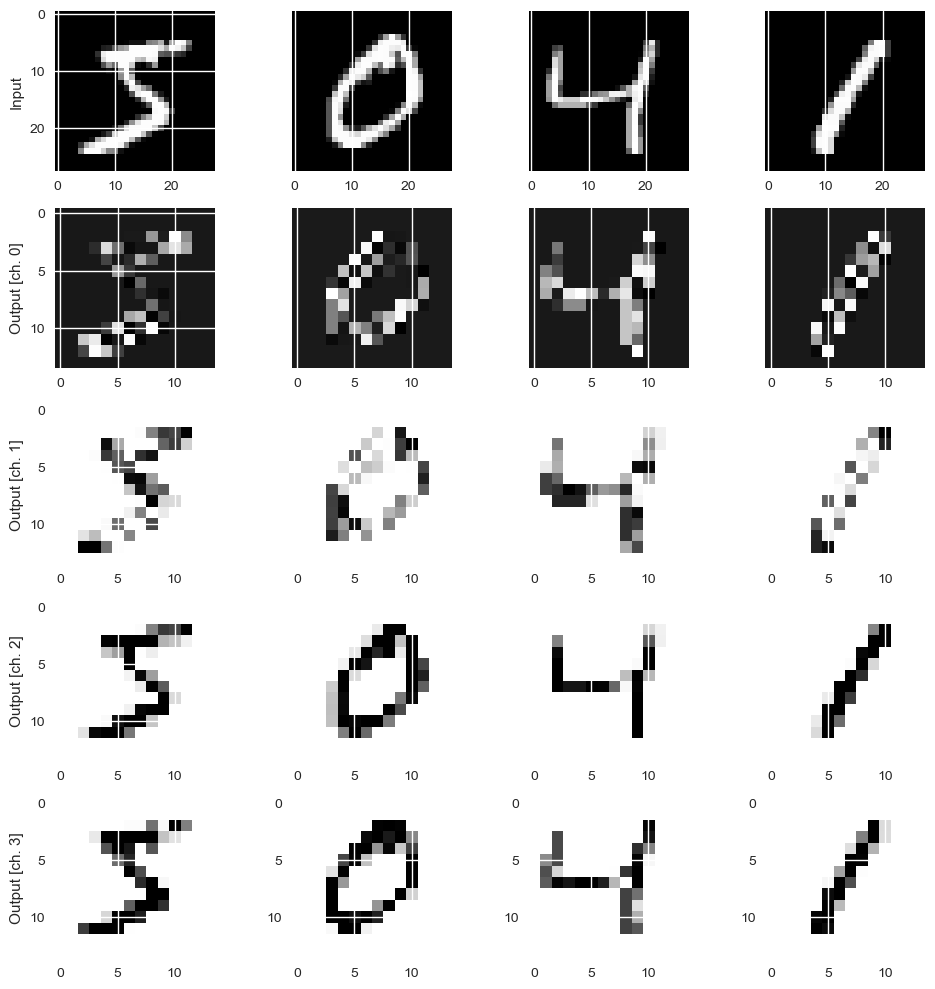

In [19]:
# VISUALIZE THE EFFECT OF THE LAYER

n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [14]:
# CREATE HYBRID QUANTUM-CLASSICAL MODEL

def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [15]:
# TRAINING OF MODEL WITH PRE-PROCESSED DATA

q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

2023-02-13 18:59:19.441112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
13/13 - 1s - loss: 2.8898 - accuracy: 0.0200 - val_loss: 2.3765 - val_accuracy: 0.1667 - 1s/epoch - 77ms/step
Epoch 2/30
13/13 - 0s - loss: 1.9608 - accuracy: 0.3400 - val_loss: 2.2677 - val_accuracy: 0.1333 - 91ms/epoch - 7ms/step
Epoch 3/30
13/13 - 0s - loss: 1.6116 - accuracy: 0.5200 - val_loss: 2.0661 - val_accuracy: 0.2667 - 91ms/epoch - 7ms/step
Epoch 4/30
13/13 - 0s - loss: 1.2202 - accuracy: 0.7000 - val_loss: 1.8719 - val_accuracy: 0.4000 - 102ms/epoch - 8ms/step
Epoch 5/30
13/13 - 0s - loss: 1.0337 - accuracy: 0.8400 - val_loss: 1.7544 - val_accuracy: 0.3667 - 77ms/epoch - 6ms/step
Epoch 6/30
13/13 - 0s - loss: 0.8613 - accuracy: 0.8400 - val_loss: 1.7185 - val_accuracy: 0.3333 - 62ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.6642 - accuracy: 0.9200 - val_loss: 1.6001 - val_accuracy: 0.5000 - 108ms/epoch - 8ms/step
Epoch 8/30
13/13 - 0s - loss: 0.5485 - accuracy: 0.9400 - val_loss: 1.5307 - val_accuracy: 0.5333 - 147ms/epoch - 11ms/step
Epoch 9/30
13/13 - 0s

In [16]:
# RESULTS OF CLASSICAL INSTANCE OF THE MODEL

c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.3060 - accuracy: 0.1200 - val_loss: 2.2536 - val_accuracy: 0.1000 - 688ms/epoch - 53ms/step
Epoch 2/30
13/13 - 0s - loss: 1.9253 - accuracy: 0.3200 - val_loss: 2.0620 - val_accuracy: 0.2333 - 73ms/epoch - 6ms/step
Epoch 3/30
13/13 - 0s - loss: 1.6251 - accuracy: 0.6600 - val_loss: 1.9020 - val_accuracy: 0.4333 - 87ms/epoch - 7ms/step
Epoch 4/30
13/13 - 0s - loss: 1.3953 - accuracy: 0.7800 - val_loss: 1.7605 - val_accuracy: 0.4667 - 83ms/epoch - 6ms/step
Epoch 5/30
13/13 - 0s - loss: 1.1977 - accuracy: 0.8800 - val_loss: 1.6422 - val_accuracy: 0.5667 - 76ms/epoch - 6ms/step
Epoch 6/30
13/13 - 0s - loss: 1.0353 - accuracy: 0.9200 - val_loss: 1.5556 - val_accuracy: 0.5333 - 72ms/epoch - 6ms/step
Epoch 7/30
13/13 - 0s - loss: 0.8973 - accuracy: 0.9200 - val_loss: 1.4890 - val_accuracy: 0.5667 - 74ms/epoch - 6ms/step
Epoch 8/30
13/13 - 0s - loss: 0.7827 - accuracy: 0.9200 - val_loss: 1.4254 - val_accuracy: 0.5667 - 68ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

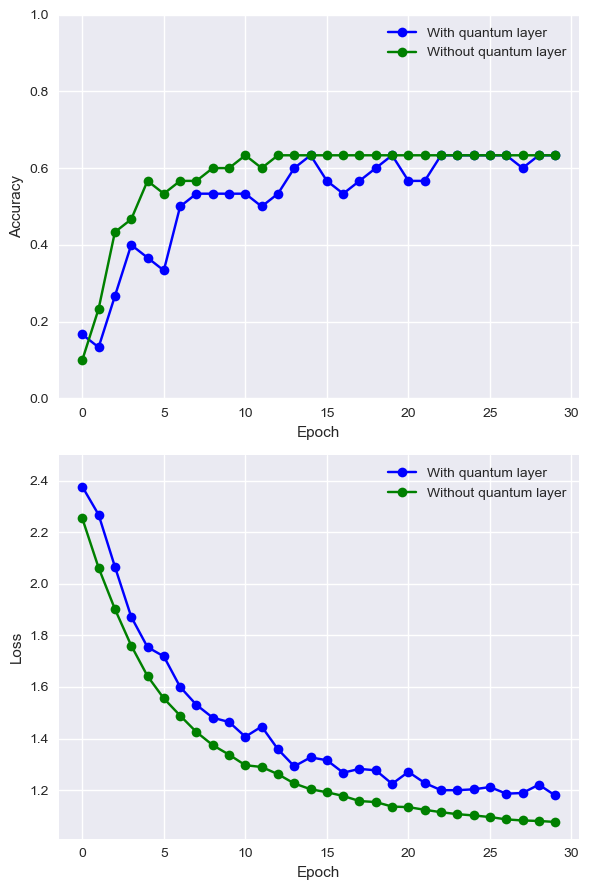

In [17]:
# VISUALIZE QUANTUM VS. CLASSICAL TEST ACCURACY

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()